In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# Imported Interbank FX Rates Historical.csv
Interbank_FX_Rates_Historical = pd.read_csv('./datasets/Interbank FX Rates Historical.csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns GBPGHS
Interbank_FX_Rates_Historical.rename(columns={'Selling': 'GBPGHS'}, inplace=True)

In [3]:
# Imported Interbank FX Rates Historical (1).csv
Interbank_FX_Rates_Historical_1 = pd.read_csv('./datasets/Interbank FX Rates Historical (1).csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical_1.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns USDGHS
Interbank_FX_Rates_Historical_1.rename(columns={'Selling': 'USDGHS'}, inplace=True)

In [4]:
# Merged Interbank_FX_Rates_Historical_1 and Interbank_FX_Rates_Historical into df3
temp_df = Interbank_FX_Rates_Historical.drop_duplicates(subset=['Date']) # Remove duplicates so lookup merge only returns first match
df = Interbank_FX_Rates_Historical_1.merge(temp_df, left_on=['Date'], right_on=['Date'], how='left', suffixes=['_Interbank_FX_Rates_Historical_1', '_Interbank_FX_Rates_Historical'])
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [5]:
# Check for missing values
print('missing values:', df.isnull().sum().sort_values(ascending = False))

missing values: Date      0
USDGHS    0
GBPGHS    0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3226 non-null   object
 1   USDGHS  3226 non-null   object
 2   GBPGHS  3226 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


In [7]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


In [8]:
df_plot = df.copy()
df.head()

,USDGHS,GBPGHS
Date,,
2008-01-02,1.9427,0.9799
2008-01-03,1.9394,0.9799
2008-01-04,1.9309,0.9798
2008-01-05,1.9309,0.9798
2008-01-06,1.9309,0.9798


<AxesSubplot:xlabel='Date'>

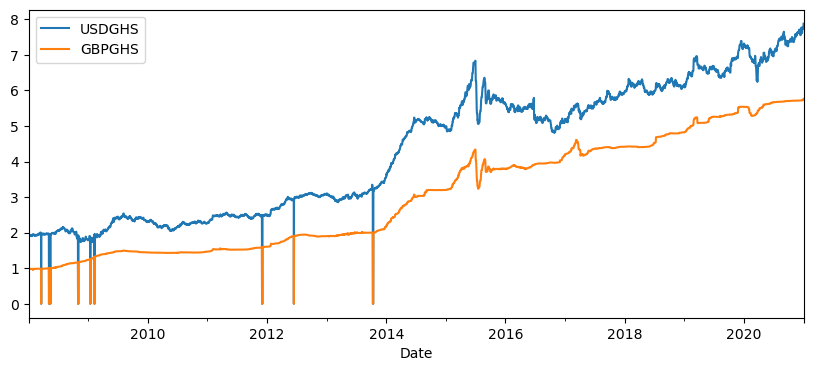

In [9]:
# Let's see a historical view of the closing price
df_plot['USDGHS'].plot(legend=True, figsize=(10,4))
df_plot['GBPGHS'].plot(legend=True, figsize=(10,4))

In [10]:
# Let's go ahead and plot out several moving averages
MA_day = [10,50,200]

for ma in MA_day:
    column_name = 'MA for %s days' %(str(ma))
    df_plot[column_name] = df_plot['USDGHS'].rolling(window=ma).mean()


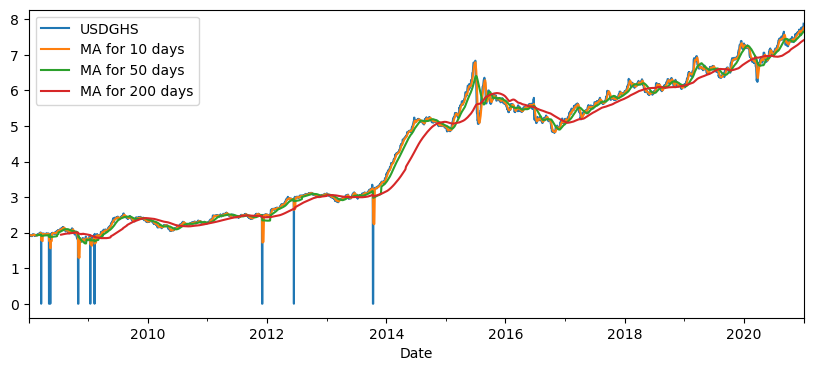

In [11]:
df_plot = df_plot[['USDGHS','MA for 10 days','MA for 50 days','MA for 200 days']].plot(subplots=False,figsize=(10,4))

In [12]:
USDGHS = df['USDGHS']
USDGHS.head()

Date
2008-01-02    1.9427
2008-01-03    1.9394
2008-01-04    1.9309
2008-01-05    1.9309
2008-01-06    1.9309
Freq: D, Name: USDGHS, dtype: float64

It is not necessary to check for autocorrelation in time series before using LSTM. However, it is important to check for autocorrelation in time series data before using any time series model. Autocorrelation is a measure of the correlation between the values of a time series at different points in time. If there is autocorrelation in the data, it means that the values of the time series at one point in time are correlated with the values at other points in time. This can lead to biased estimates of the model parameters and can affect the accuracy of the model predictions

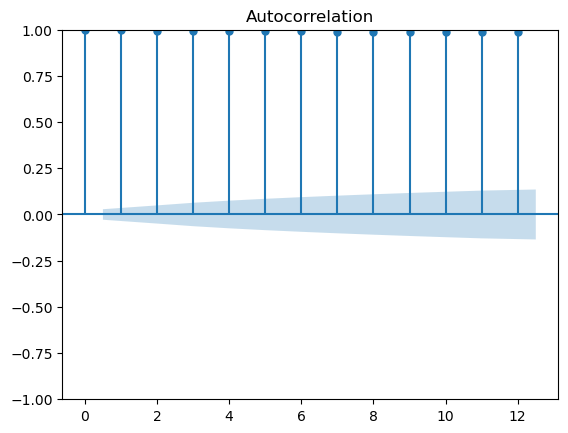

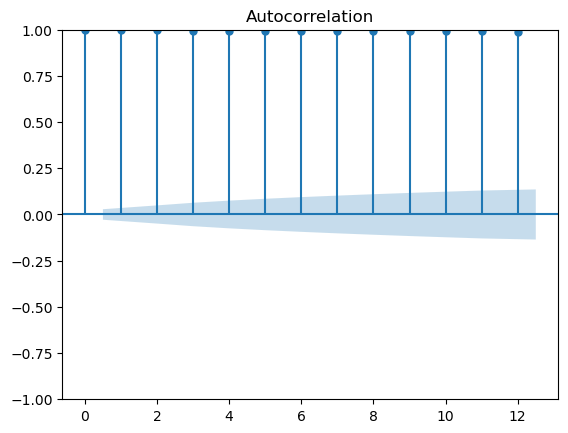

In [13]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(df["USDGHS"], lags=12)
fig = tsaplots.plot_acf(df["GBPGHS"], lags=12)
plt.show()

In [14]:
print('the shape of the  dataset is ', USDGHS.shape)

the shape of the  dataset is  (4748,)


### Transforming the time series into well labelled training and testing dataset 

We will use the following function to transform time series into well labelled braining training and target samples. i.e we transform out input into a tuple (n_samples,n_timesteps,n_features)

In [15]:
def Model_data_setup(data, lookback, delay, min_index, max_index):
    """
    data:     Shape (n_samples, n_features). First column is the time series, other columns are the features.
              If there is only one column, it is assumed to be the time series data.
    lookback: Number of time steps in the Model >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x, y) of numpy arrays where x is in shape (n_samples, n_timesteps, n_features) and 
             y is in shape (n_samples, delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    """
    if data.ndim == 1:
        data = np.expand_dims(data, axis=1)
    n_samples = max_index - lookback - delay + 1
    x_shape = (n_samples, lookback, data.shape[1])
    x = np.zeros(x_shape)
    y_shape = (n_samples, delay)
    y = np.zeros(y_shape)

    for i in range(n_samples):
        start_index = i + min_index
        end_index = start_index + lookback
        x[i,:,:] = data[start_index:end_index,:]
        y[i,:] = data[end_index + delay - 1, 0]

    return x, y


In [16]:
xdata, ydata = Model_data_setup(USDGHS.values, lookback=5, delay=1, min_index=0, max_index=len(USDGHS)-1)


### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock prices into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [17]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6) # 2416#
valid_size = int(len(xdata)*0.2) #605#
test_size = len(xdata) - train_size-valid_size #355#

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (2845, 5, 1)
The shape of the validation sample is:  (948, 5, 1)
The shape of the testing sample is:  (949, 5, 1)
The shape of the training target is:  (2845, 1)
The shape of the validation target is:  (948, 1)
The shape of the testing target is:  (949, 1)


In [18]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xvalid = np.reshape(xvalid, (xvalid.shape[0], xvalid.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))


## Neural Networks Models

In [19]:
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM,GRU,Conv1D, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam


The RNNs have a feedback mechanism that allows them to take into account the previous inputs in the sequence while making predictions. This feedback loop creates a kind of memory within the network, which is why RNNs are well-suited for sequential data. The mathematical representation of an RNN is:

\begin{equation}
h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
\end{equation}

where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, $W_{hh}$ is the weight matrix for the hidden-to-hidden connections, $W_{xh}$ is the weight matrix for the input-to-hidden connections, $b_h$ is the bias term, and $f$ is an activation function.



LSTM networks are a type of RNN that are designed to address the vanishing gradient problem that can occur in traditional RNNs. LSTM networks use memory cells and gates to selectively remember or forget information from previous inputs. The mathematical representation of an LSTM network is:

\begin{align}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
\tilde{C}t &= \tanh(W_C \cdot [h{t-1}, x_t] + b_C) \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
h_t &= o_t * \tanh(C_t)
\end{align}

where $f_t$ is the forget gate, $i_t$ is the input gate, $o_t$ is the output gate, $\tilde{C}_t$ is the candidate cell state, $C_t$ is the cell state, and $h_t$ is the hidden state. $W_f$, $W_i$, $W_o$, and $W_C$ are the weight matrices, and $b_f$, $b_i$, $b_o$, and $b_C$ are the bias terms. $\sigma$ is the sigmoid activation function, and $\tanh$ is the hyperbolic tangent activation function.

Let's consider a sequence of two-dimensional data, represented as a tensor $X$ of shape $(num_timesteps, height, width, channels)$. At each time step $t$, the input $X[t]$ is processed by a ConvLSTM cell, which consists of several operations.

First, the cell applies a convolution operation to the input $X[t]$ and the previous hidden state $H[t-1]$, with a set of filters $W_x$ and $W_h$, respectively. The output of this convolution is a set of feature maps $F[t]$:

$$F[t] = \text{Conv}(X[t], W_x) + \text{Conv}(H[t-1], W_h)$$

Next, the cell applies several gating mechanisms to control the flow of information through the network. Specifically, it computes three gates: the input gate $i[t]$, the forget gate $f[t]$, and the output gate $o[t]$:

\begin{align*}
i[t] &= \sigma(\text{Conv}(X[t], W_i) + \text{Conv}(H[t-1], U_i)) \\
f[t] &= \sigma(\text{Conv}(X[t], W_f) + \text{Conv}(H[t-1], U_f)) \\
o[t] &= \sigma(\text{Conv}(X[t], W_o) + \text{Conv}(H[t-1], U_o))
\end{align*}

where $\sigma$ represents the sigmoid activation function, and $W_i$, $W_f$, $W_o$, $U_i$, $U_f$, and $U_o$ are the weights for the convolutional filters used to compute each gate.

These gates control which information is passed through the cell, and which information is discarded. The input gate $i[t]$ determines how much of the new input $F[t]$ is added to the memory cell $C[t]$, which stores the current state of the cell:

$$C[t] = i[t] \cdot \tanh(\text{Conv}(X[t], W_c) + \text{Conv}(H[t-1], U_c)) + f[t] \cdot C[t-1]$$

where $\tanh$ represents the hyperbolic tangent activation function, and $W_c$ and $U_c$ are the weights for the convolutional filters used to compute the cell state.

Finally, the output gate $o[t]$ determines the output of the cell:

$$H[t] = o[t] \cdot \tanh(C[t])$$

where $H[t]$ is the output of the cell at time ste

In [20]:
n_features = USDGHS.shape
lr = 0.0016#Learning rate
units = 16 #Number hidden units
batch_size=64
lookback = 5
delay = 1
min_index = 0
max_index = USDGHS.shape[0] - 1

# Define the number of features in the input data
n_features = 1  # We only have one feature, which is the USDGHS exchange rate

# Convert the data into the required format for the model
xdata, ydata = Model_data_setup(USDGHS.values.reshape(-1, 1), lookback, delay, min_index, max_index)


RNN model using the Sequential class from the `tf.keras.models` module. The model consists of three layers: an input layer, a SimpleRNN layer, and a Dense layer.

The Input layer specifies the shape of the input data, which is a 3D tensor with shape `(n_timesteps, n_features)` where `n_timesteps` is the number of time steps in each input sequence and n_features is the number of features in each time step.

The SimpleRNN layer is a type of RNN layer that uses the recurrent activation function tanh by default. It has 64 units and uses the `relu` activation function. This layer takes the input sequences as input and outputs a sequence of hidden states.

The Dense layer is a fully connected layer that takes the last hidden state from the SimpleRNN layer and outputs a single value, which is the predicted value for the next time step.

In [21]:
#define of RNN model
RNN = Sequential()
RNN.add(SimpleRNN(units, activation = 'tanh', 
                                  input_shape = (lookback, n_features), 
                                  return_sequences =False,recurrent_dropout=0.3))
\
RNN.add(Dense(1))
opt = Adam(lr)#, decay=1e-6)
RNN.compile(optimizer = 'Adam' , loss = 'mse', metrics=["mae"])
RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                288       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Define the LSTM model
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(32, activation='tanh',
                input_shape = (lookback,n_features),
                return_sequences = True))#,recurrent_dropout=0.3))


LSTM_Model.add(LSTM(32))
#model2.add(Dropout(0.5))
LSTM_Model.add(Dense(1))
opt = Adam(learning_rate=0.02)#, decay=1e-6)
LSTM_Model.compile(loss='mse', optimizer=opt , metrics=["mae"])
LSTM_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [23]:
# define  of GRU model
GRU_Model = Sequential()
GRU_Model.add(GRU(128, activation='tanh', input_shape=(lookback, n_features)))
# GRU_Model.add(Dropout(0.1801))
GRU_Model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.0114)
GRU_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
GRU_Model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Define MLP model
MLP_Model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(lookback,n_features,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

MLP_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
MLP_Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5, 64)             128       
                                                                 
 dense_4 (Dense)             (None, 5, 32)             2080      
                                                                 
 dense_5 (Dense)             (None, 5, 1)              33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Define Conv1D model
conv1D_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(1)
])

conv1D_Model.compile(optimizer = opt, loss='mse', metrics=["mae"])
conv1D_Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 97        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


## Fitting All The Models

In [26]:
np.random.seed(123)
history_1=RNN.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)

Epoch 1/50
89/89 [==============================] - 6s 29ms/step - loss: 9.3195 - mae: 2.5057 - val_loss: 14.6601 - val_mae: 3.8032
Epoch 2/50
89/89 [==============================] - 2s 25ms/step - loss: 2.0433 - mae: 0.9999 - val_loss: 5.3591 - val_mae: 2.2766
Epoch 3/50
89/89 [==============================] - 2s 26ms/step - loss: 1.1932 - mae: 0.8036 - val_loss: 2.9801 - val_mae: 1.6872
Epoch 4/50
89/89 [==============================] - 2s 28ms/step - loss: 0.7964 - mae: 0.6743 - val_loss: 1.8564 - val_mae: 1.3220
Epoch 5/50
89/89 [==============================] - 2s 24ms/step - loss: 0.5903 - mae: 0.5793 - val_loss: 1.1554 - val_mae: 1.0301
Epoch 6/50
89/89 [==============================] - 2s 22ms/step - loss: 0.4424 - mae: 0.4931 - val_loss: 0.7619 - val_mae: 0.8236
Epoch 7/50
89/89 [==============================] - 2s 21ms/step - loss: 0.3613 - mae: 0.4545 - val_loss: 0.5159 - val_mae: 0.6634
Epoch 8/50
89/89 [==============================] - 2s 24ms/step - loss: 0.2938 - 

In [27]:
RNN_df = pd.DataFrame(history_1.history)
RNN_df.tail()

,loss,mae,val_loss,val_mae
45,0.044389,0.104153,0.052382,0.208997
46,0.045696,0.103038,0.053529,0.212216
47,0.043317,0.100557,0.090070,0.284240
48,0.043728,0.101109,0.057066,0.221380
49,0.044578,0.097909,0.048330,0.202837


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


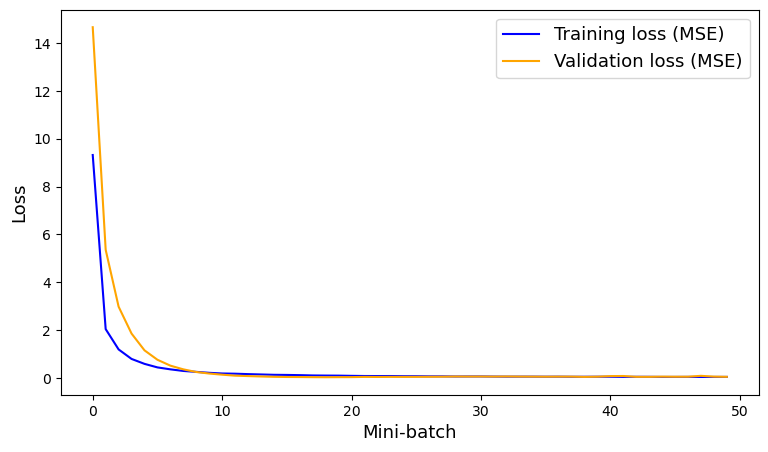

In [28]:
print('')
plt.figure(figsize=(9,5))
plt.plot(RNN_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(RNN_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error1.eps', format='eps', dpi=1000)
plt.show()

In [29]:
np.random.seed(123)
history_2=LSTM_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)

Epoch 1/50
89/89 [==============================] - 22s 94ms/step - loss: 0.6423 - mae: 0.4284 - val_loss: 0.0177 - val_mae: 0.1044
Epoch 2/50
89/89 [==============================] - 5s 58ms/step - loss: 0.0372 - mae: 0.0829 - val_loss: 0.0121 - val_mae: 0.0980
Epoch 3/50
89/89 [==============================] - 5s 53ms/step - loss: 0.0332 - mae: 0.0734 - val_loss: 0.0112 - val_mae: 0.0948
Epoch 4/50
89/89 [==============================] - 5s 54ms/step - loss: 0.0358 - mae: 0.0883 - val_loss: 0.0115 - val_mae: 0.0971
Epoch 5/50
89/89 [==============================] - 5s 56ms/step - loss: 0.0304 - mae: 0.0744 - val_loss: 0.0756 - val_mae: 0.2719
Epoch 6/50
89/89 [==============================] - 6s 63ms/step - loss: 0.0315 - mae: 0.0791 - val_loss: 0.0052 - val_mae: 0.0586
Epoch 7/50
89/89 [==============================] - 5s 61ms/step - loss: 0.0286 - mae: 0.0670 - val_loss: 0.0433 - val_mae: 0.2045
Epoch 8/50
89/89 [==============================] - 4s 50ms/step - loss: 0.0331 - 

In [30]:
LSTM_df = pd.DataFrame(history_2.history)
LSTM_df.tail()

,loss,mae,val_loss,val_mae
45,0.024185,0.056039,0.008082,0.079840
46,0.022649,0.046241,0.005163,0.063820
47,0.023570,0.054483,0.018504,0.129899
48,0.023252,0.049635,0.003308,0.047629
49,0.025317,0.058524,0.007021,0.075259


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


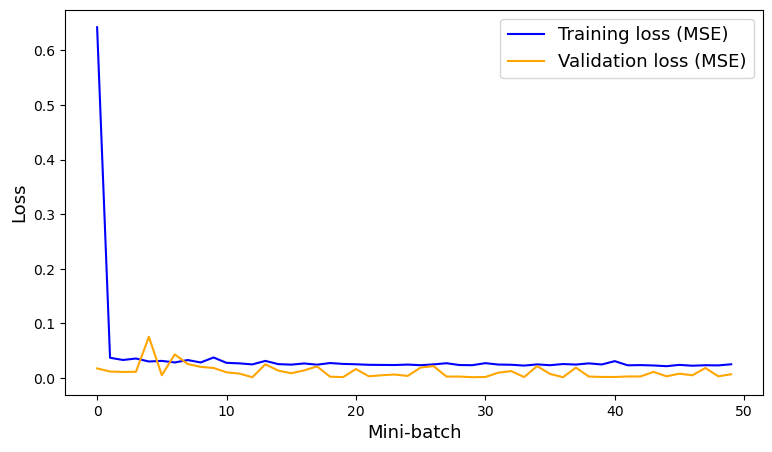

In [31]:
print('')
plt.figure(figsize=(9,5))
plt.plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/LSTM_error1.eps', format='eps', dpi=1000)
plt.show()

In [32]:
np.random.seed(123)
history_3=GRU_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)

Epoch 1/50
89/89 [==============================] - 25s 88ms/step - loss: 0.2758 - mae: 0.2369 - val_loss: 0.0263 - val_mae: 0.1422
Epoch 2/50
89/89 [==============================] - 4s 45ms/step - loss: 0.0314 - mae: 0.0526 - val_loss: 0.0026 - val_mae: 0.0395
Epoch 3/50
89/89 [==============================] - 5s 54ms/step - loss: 0.0289 - mae: 0.0563 - val_loss: 0.0120 - val_mae: 0.1010
Epoch 4/50
89/89 [==============================] - 4s 45ms/step - loss: 0.0278 - mae: 0.0602 - val_loss: 0.0020 - val_mae: 0.0323
Epoch 5/50
89/89 [==============================] - 4s 47ms/step - loss: 0.0261 - mae: 0.0525 - val_loss: 0.0155 - val_mae: 0.1176
Epoch 6/50
89/89 [==============================] - 4s 44ms/step - loss: 0.0268 - mae: 0.0577 - val_loss: 0.0044 - val_mae: 0.0546
Epoch 7/50
89/89 [==============================] - 4s 45ms/step - loss: 0.0265 - mae: 0.0549 - val_loss: 0.0059 - val_mae: 0.0635
Epoch 8/50
89/89 [==============================] - 4s 43ms/step - loss: 0.0261 - 

In [33]:
GRU_df =pd.DataFrame(history_3.history)
GRU_df.tail()

,loss,mae,val_loss,val_mae
45,0.024425,0.050568,0.046343,0.211241
46,0.025369,0.060084,0.014805,0.116577
47,0.025713,0.064760,0.014719,0.116281
48,0.025663,0.058339,0.001639,0.029348
49,0.023896,0.048624,0.007012,0.076661


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


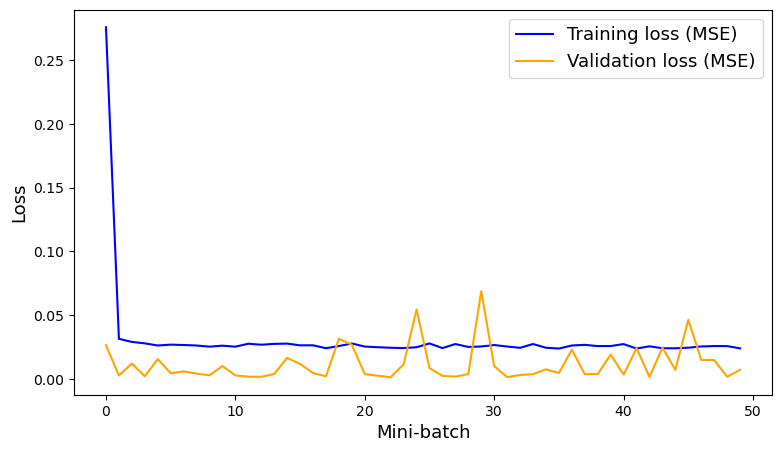

In [34]:
plt.figure(figsize=(9,5))
plt.plot(GRU_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(GRU_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/GRU_error1.eps', format='eps', dpi=1000)
plt.show()

In [35]:
np.random.seed(123)
history_4 = MLP_Model.fit(xtrain, ytrain,
                          epochs=50,
                          validation_data=(xvalid, yvalid))

Epoch 1/50
89/89 [==============================] - 4s 23ms/step - loss: 0.6739 - mae: 0.4275 - val_loss: 0.0035 - val_mae: 0.0415
Epoch 2/50
89/89 [==============================] - 2s 17ms/step - loss: 0.0439 - mae: 0.0500 - val_loss: 0.0047 - val_mae: 0.0528
Epoch 3/50
89/89 [==============================] - 2s 18ms/step - loss: 0.0440 - mae: 0.0588 - val_loss: 0.0079 - val_mae: 0.0754
Epoch 4/50
89/89 [==============================] - 2s 19ms/step - loss: 0.0426 - mae: 0.0534 - val_loss: 0.0040 - val_mae: 0.0458
Epoch 5/50
89/89 [==============================] - 1s 16ms/step - loss: 0.0418 - mae: 0.0546 - val_loss: 0.0033 - val_mae: 0.0392
Epoch 6/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0410 - mae: 0.0517 - val_loss: 0.0033 - val_mae: 0.0394
Epoch 7/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0402 - mae: 0.0498 - val_loss: 0.0033 - val_mae: 0.0388
Epoch 8/50
89/89 [==============================] - 2s 18ms/step - loss: 0.0399 - m

In [36]:
MLP_df =pd.DataFrame(history_4.history)
MLP_df.tail()

,loss,mae,val_loss,val_mae
45,0.037283,0.066701,0.036455,0.183793
46,0.035814,0.060067,0.017903,0.123961
47,0.036657,0.067951,0.021345,0.134443
48,0.036640,0.064972,0.004038,0.047128
49,0.036069,0.060725,0.003360,0.039817


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


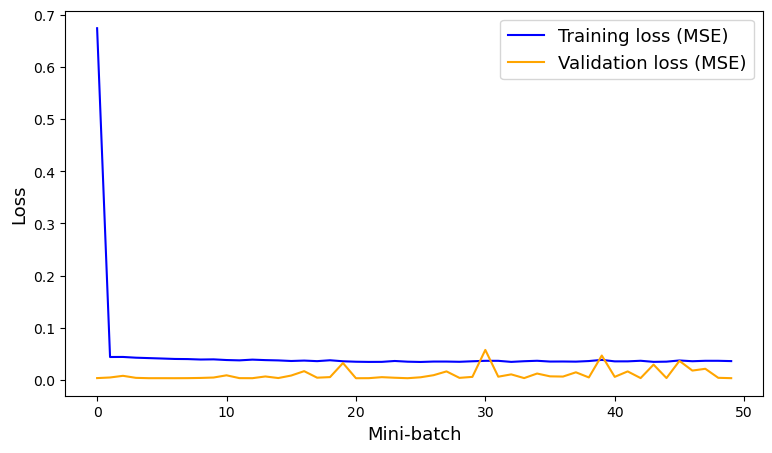

In [37]:
plt.figure(figsize=(9,5))
plt.plot(MLP_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(MLP_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/MLP_Model.eps', format='eps', dpi=1000)
plt.show()

In [38]:
np.random.seed(1)
history_5 = conv1D_Model.fit(xtrain,ytrain,batch_size=300,epochs=150,validation_data=(xvalid,yvalid), verbose = 1)


Epoch 1/150
10/10 [==============================] - 2s 75ms/step - loss: 3.8935 - mae: 1.6032 - val_loss: 0.8145 - val_mae: 0.8990
Epoch 2/150
10/10 [==============================] - 0s 40ms/step - loss: 0.5676 - mae: 0.6219 - val_loss: 2.0038 - val_mae: 1.4114
Epoch 3/150
10/10 [==============================] - 0s 30ms/step - loss: 0.2587 - mae: 0.4079 - val_loss: 0.3782 - val_mae: 0.6111
Epoch 4/150
10/10 [==============================] - 0s 49ms/step - loss: 0.1288 - mae: 0.2667 - val_loss: 0.0258 - val_mae: 0.1535
Epoch 5/150
10/10 [==============================] - 0s 40ms/step - loss: 0.0624 - mae: 0.1400 - val_loss: 0.0187 - val_mae: 0.1284
Epoch 6/150
10/10 [==============================] - 0s 36ms/step - loss: 0.0519 - mae: 0.1184 - val_loss: 0.0110 - val_mae: 0.0955
Epoch 7/150
10/10 [==============================] - 0s 45ms/step - loss: 0.0422 - mae: 0.0856 - val_loss: 0.0289 - val_mae: 0.1641
Epoch 8/150
10/10 [==============================] - 0s 46ms/step - loss: 0.

In [39]:
conv1D_df = pd.DataFrame(history_5.history)
conv1D_df.tail()

,loss,mae,val_loss,val_mae
145,0.027986,0.034913,0.002291,0.037932
146,0.027952,0.035261,0.001376,0.024559
147,0.027807,0.032812,0.001396,0.025057
148,0.027924,0.037065,0.006182,0.071563
149,0.028536,0.043376,0.001400,0.025176


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


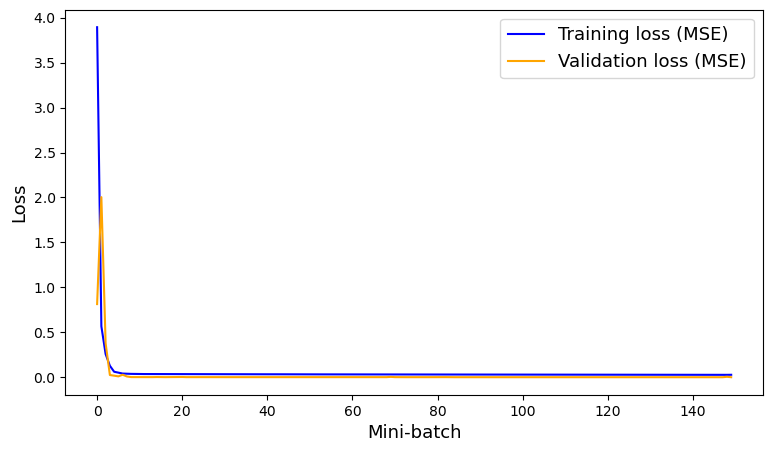

In [40]:
print('')
plt.figure(figsize=(9,5))
plt.plot(conv1D_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(conv1D_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/conv1D_Model.eps', format='eps', dpi=1000)
plt.show()

## Predictions
Now we will use our model to make predictions.

In [41]:
real_pred1 = RNN.predict(xtest)
real_pred2 = LSTM_Model.predict(xtest)
real_pred3 = GRU_Model.predict(xtest)
real_pred4 = MLP_Model.predict(xtest)
real_pred5 = conv1D_Model.predict(xtest)

30/30 [==============================] - 0s 5ms/step


In [42]:
real_pred1.shape,real_pred2.shape,real_pred3.shape,real_pred4.shape,real_pred5.shape

((949, 1), (949, 1), (949, 1), (949, 5, 1), (949, 1))

In [43]:
# Combined Models
Pred_Data = pd.DataFrame({
    'RNN': real_pred1[:,0].flatten(),
    'LSTM': real_pred2[:,0].flatten(),
    'GRU': real_pred3[:,0].flatten(),
    'MLP': real_pred4[:,0,0].flatten(),  # fixed typo here
    'conv1D': real_pred5[:,0].flatten(),  # fixed typo here
    'Actual Price': xtest[:,0].flatten()
})

Pred_Data.head()


,RNN,LSTM,GRU,MLP,conv1D,Actual Price
0,6.045084,5.838337,5.827900,5.928592,5.910731,5.9385
1,6.045076,5.830368,5.826048,5.887197,5.909809,5.8972
2,6.017006,5.772889,5.792644,5.908346,5.889034,5.9183
3,6.013174,5.781819,5.784321,5.908346,5.874527,5.9183
4,6.013350,5.781435,5.787006,5.908346,5.870692,5.9183


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


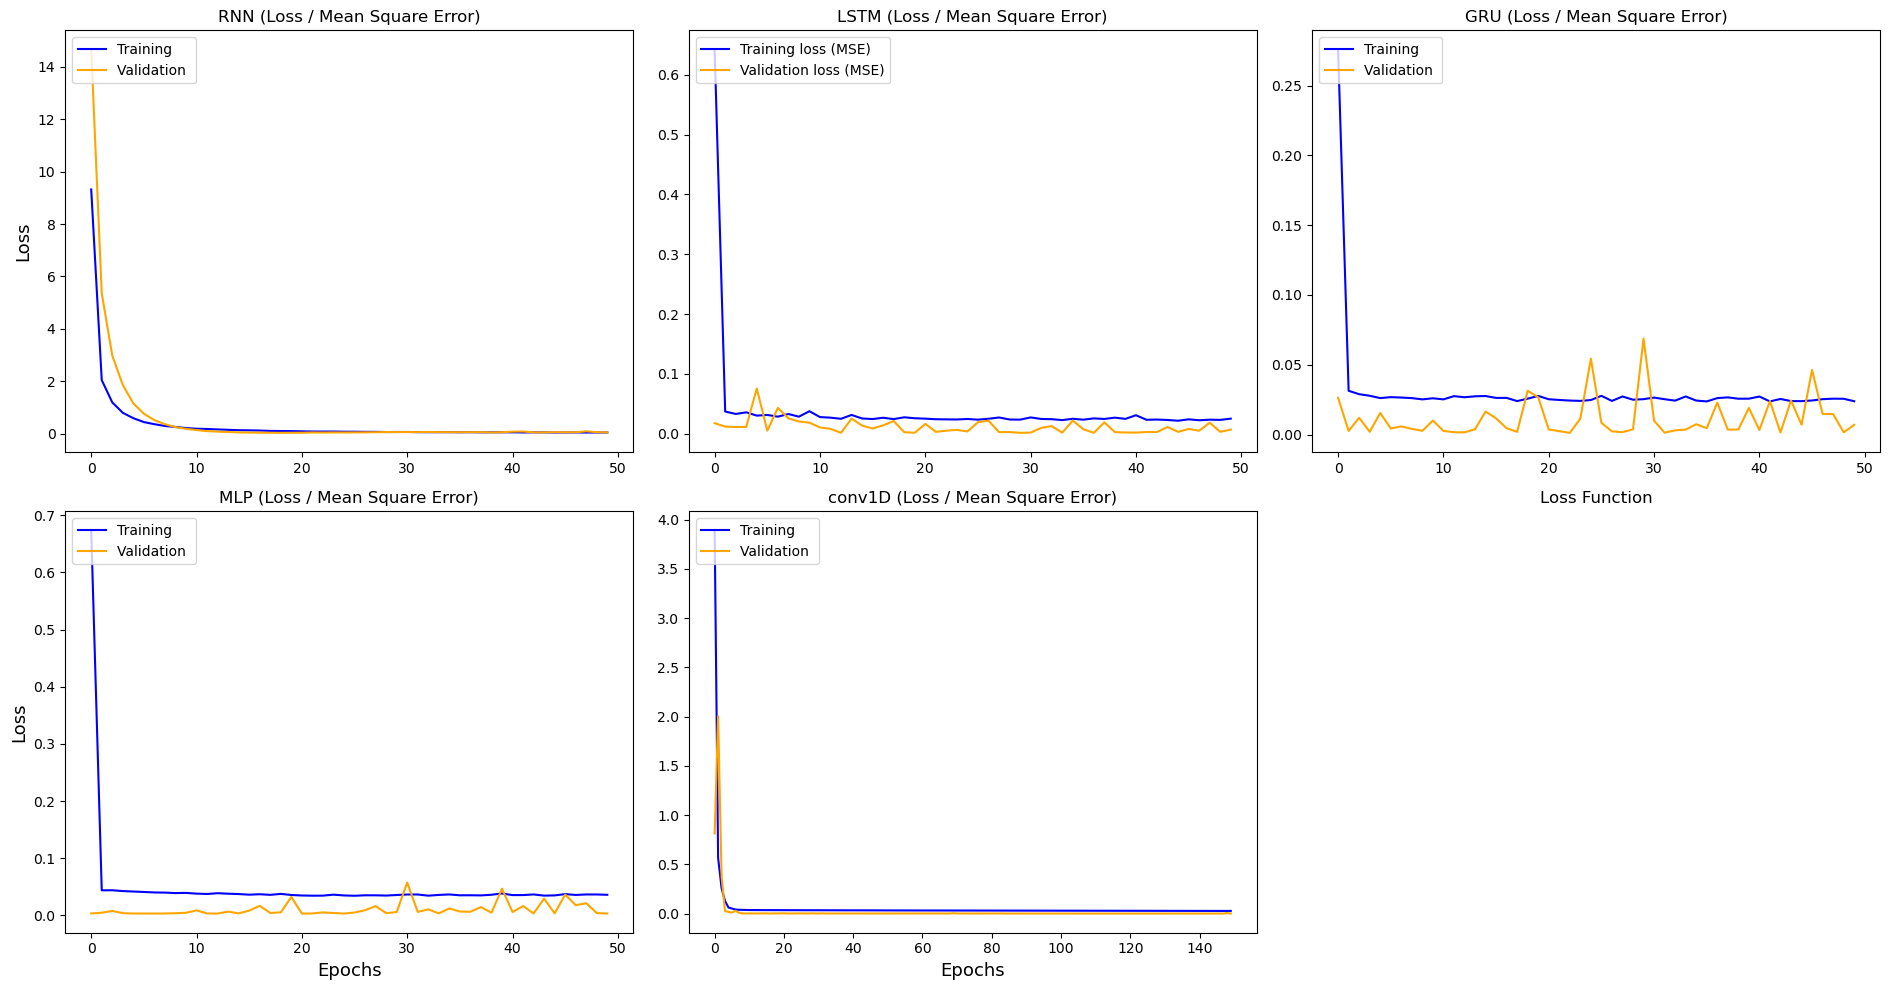

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,10))

axs[0,0].plot(RNN_df['loss'], label ='Training ', color = 'blue')
axs[0,0].plot(RNN_df['val_loss'], label='Validation ', color = 'orange')
axs[0,0].set_title('RNN (Loss / Mean Square Error)')

axs[0,1].plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
axs[0,1].plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
axs[0,1].set_title('LSTM (Loss / Mean Square Error)')

axs[0,2].plot(GRU_df['loss'], label ='Training ', color = 'blue')
axs[0,2].plot(GRU_df['val_loss'], label='Validation ', color = 'orange')
axs[0,2].set_title('GRU (Loss / Mean Square Error)')

axs[1,0].plot(MLP_df['loss'], label ='Training ', color = 'blue')
axs[1,0].plot(MLP_df['val_loss'], label='Validation ', color = 'orange')
axs[1,0].set_title('MLP (Loss / Mean Square Error)')

axs[1,1].plot(conv1D_df['loss'], label ='Training', color = 'blue')
axs[1,1].plot(conv1D_df['val_loss'], label='Validation ', color = 'orange')
axs[1,1].set_title('conv1D (Loss / Mean Square Error)')

axs[1,2].set_title('Loss Function')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')
#Add legend to all plots
axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Epochs', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('Loss', fontsize=13)
    


    
plt.tight_layout()
plt.savefig('images/Combined3.eps', format='eps', dpi=1000)
plt.show()


## Combined Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


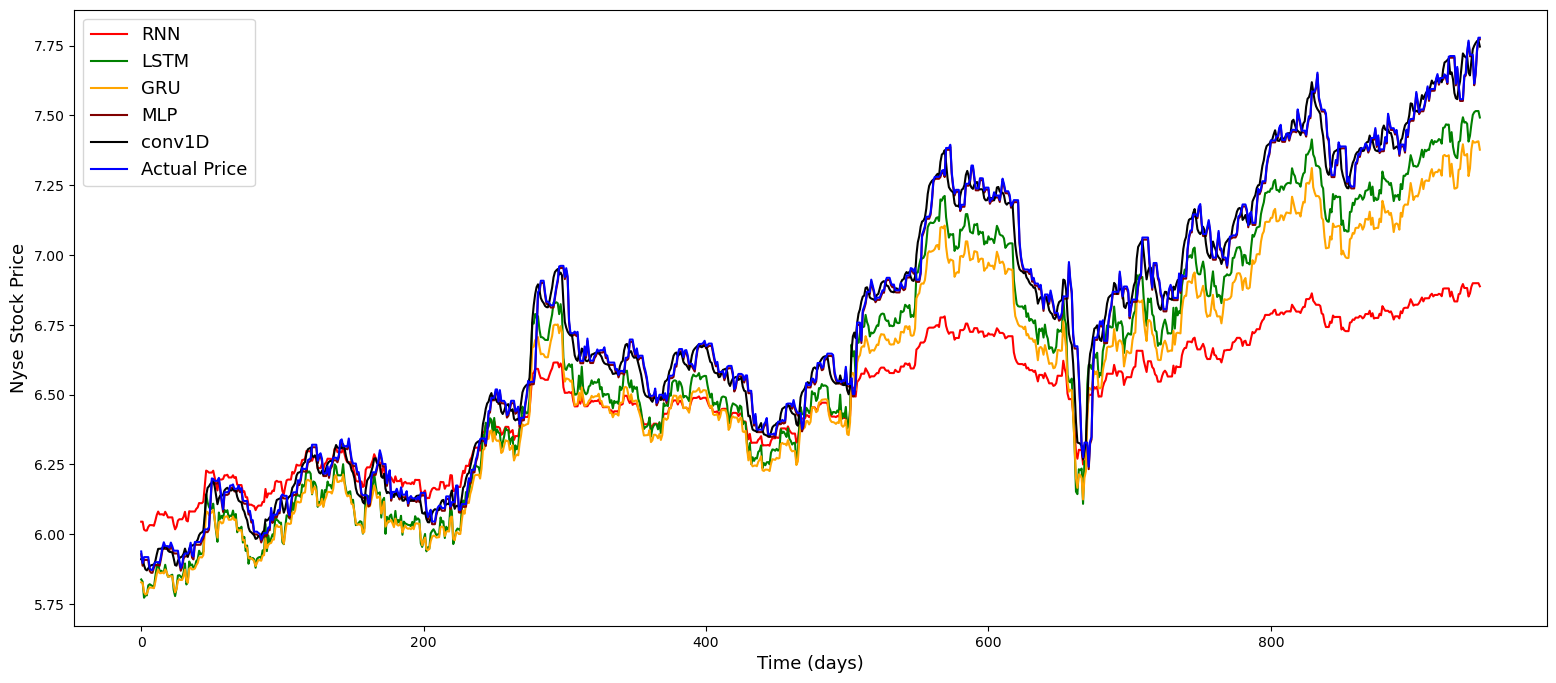

In [45]:

plt.figure(figsize=(19,8))
plt.plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
plt.plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
plt.plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
plt.plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
plt.plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
plt.plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Nyse Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('images/Combined1.eps', format='eps', dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


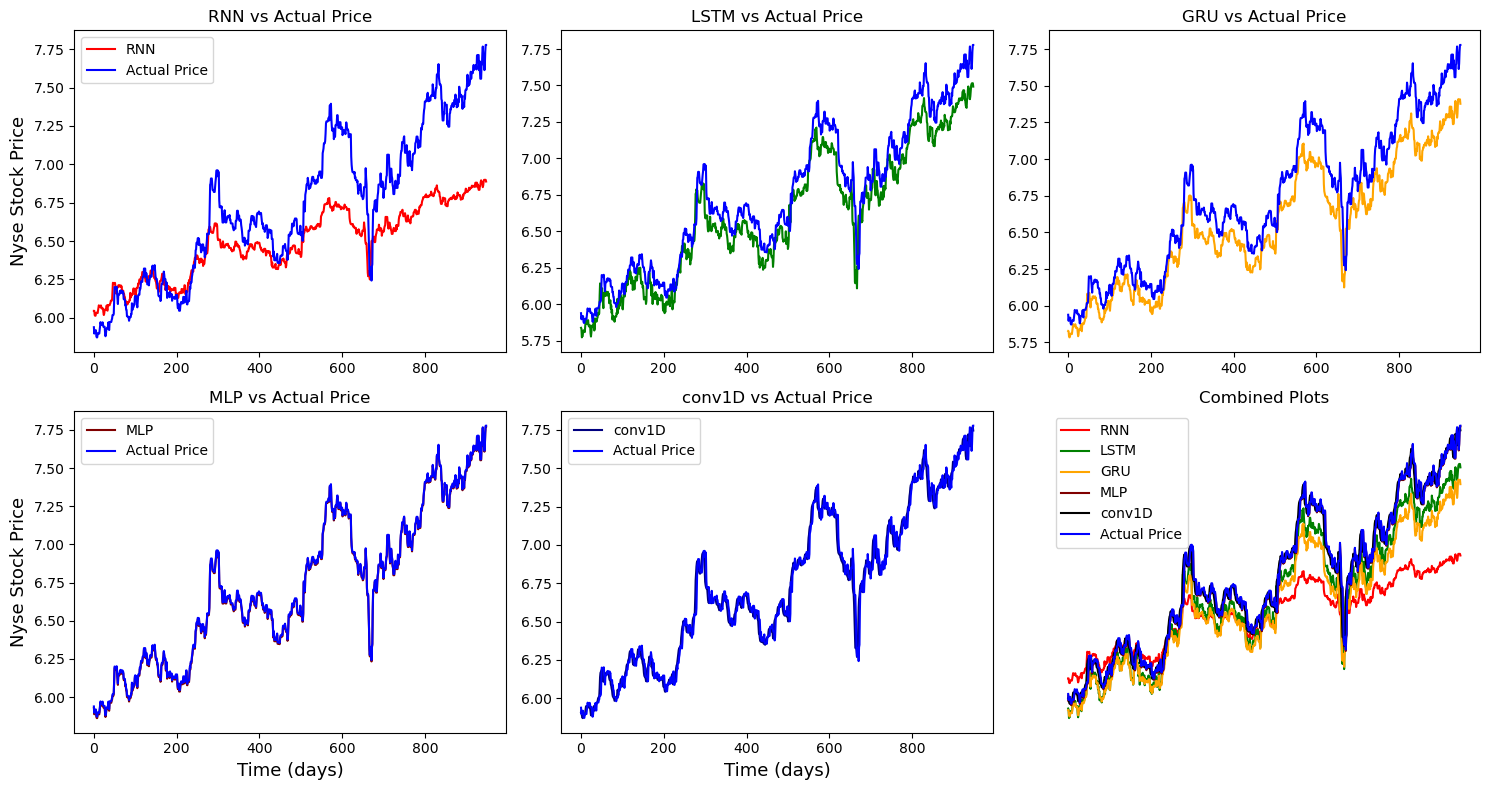

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

axs[0,0].plot(Pred_Data['RNN'], color='red', label='RNN')
axs[0,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[0,0].set_title('RNN vs Actual Price')

axs[0,1].plot(Pred_Data['LSTM'], color='green', label='LSTM')
axs[0,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[0,1].set_title('LSTM vs Actual Price')

axs[0,2].plot(Pred_Data['GRU'], color='orange', label='GRU')
axs[0,2].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[0,2].set_title('GRU vs Actual Price')

axs[1,0].plot(Pred_Data['MLP'], color='maroon', label='MLP')
axs[1,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[1,0].set_title('MLP vs Actual Price')

axs[1,1].plot(Pred_Data['conv1D'], color='navy', label='conv1D')
axs[1,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
axs[1,1].set_title('conv1D vs Actual Price')

axs[1,2].plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
axs[1,2].plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
axs[1,2].plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
axs[1,2].plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
axs[1,2].plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
axs[1,2].plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Price')

axs[1,2].set_title('Combined Plots')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')

axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
axs[1,2].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Time (days)', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('Nyse Stock Price', fontsize=13)
    

plt.tight_layout()
plt.savefig('images/Combined2.eps', format='eps', dpi=1000)
plt.show()


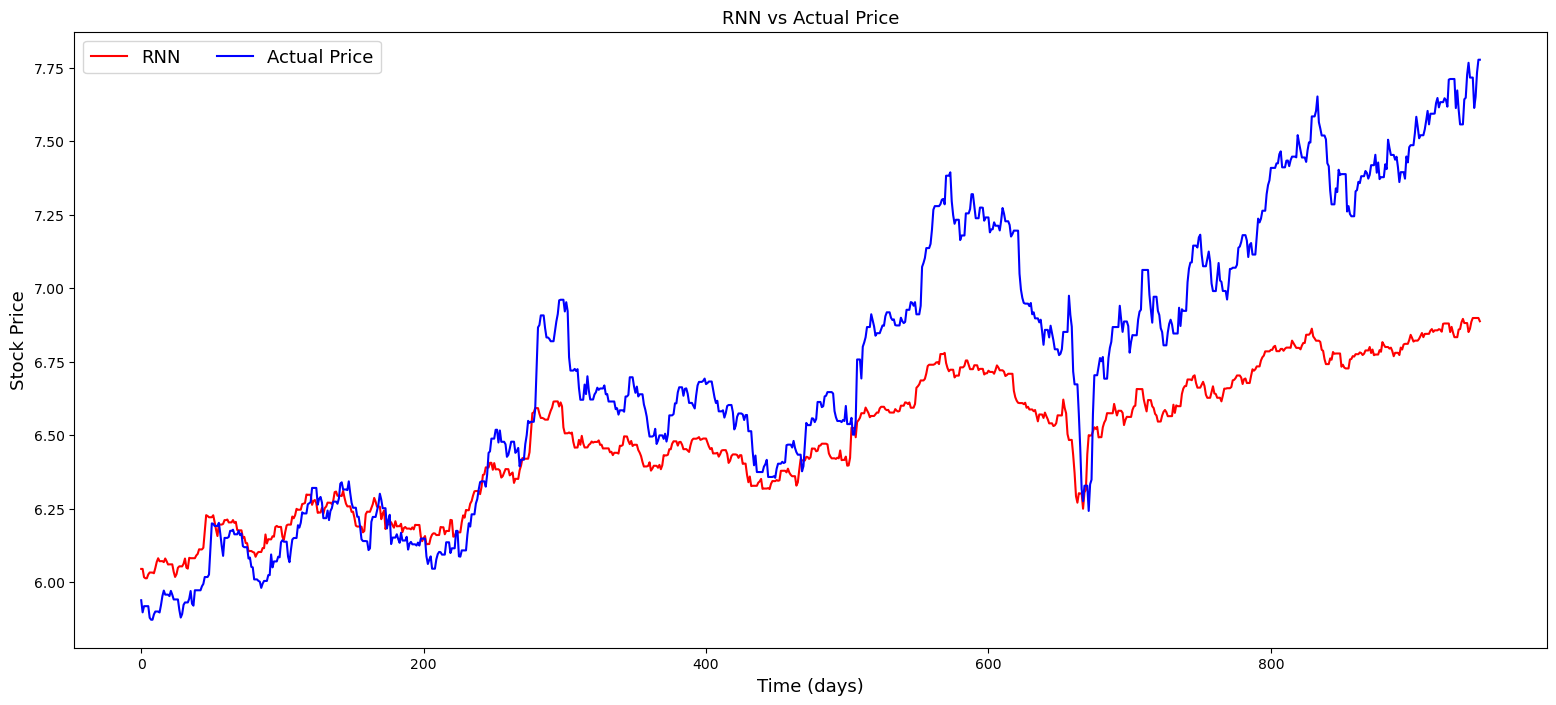

In [47]:
plt.figure(figsize=(19,8))
plt.plot(Pred_Data['RNN'], color='red', label='RNN')
plt.plot(xtest[:,0,0].flatten(), color='blue', label='Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.title('RNN vs Actual Price', fontsize=13)
plt.legend(fontsize=13,loc='upper left', ncol=2)
plt.show()


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = []  # list of models

models.append(('RNN', RNN))
models.append(('LSTM', LSTM_Model))
models.append(('GRU', GRU_Model))
models.append(('MLP', MLP_Model))
models.append(('Conv1D', conv1D_Model))

mse = []
rmse = []
mae = []
r2 = []
mape = []
y_pred = []

for model in models:
    y_pred.append(model[1].predict(xtest))
# y_pred = np.concatenate(y_pred)  # concatenate the arrays into a single array
mse.append(mean_squared_error(ytest, y_pred))
rmse.append(np.sqrt(mean_squared_error(ytest, y_pred)))
mae.append(mean_absolute_error(ytest, y_pred))
r2.append(r2_score(ytest, y_pred))
mape.append(np.mean(np.abs((ytest - y_pred) / ytest)) * 100)

model_names = [model[0] for model in models]
results_df = pd.DataFrame({'Model': model_names, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape})



30/30 [==============================] - 0s 7ms/step


ValueError: Found input variables with inconsistent numbers of samples: [949, 5]

In [ ]:
print('The the mean squared error committed by the standard MLP model is ', mean_squared_error(actual_values,predictions))
print('The squaroot of the mean squared error committed by the standard MLP model is ', np.sqrt(mean_squared_error(actual_values,predictions)))
print('The the mean absolute percentage error committed by the standard MLP model is: ', mean_absolute_percentage_error(actual_values,predictions))